In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable


import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from data_utils import create_validation_data


import torch.backends as k



In [ ]:

use_gpu = torch.cuda.is_available()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

In [ ]:
DATA_DIR = 'F:/Diba/casia_2000_class/'
train_dir = f'{DATA_DIR}train'
valid_dir = f'{DATA_DIR}valid'

sz = 160
batch_size = 8
embed_size = 128
num_epochs = 50




In [ ]:
# make validation dataset
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.20, ext='jpg')

In [ ]:
print(train_dir)
print(valid_dir)

F:/Diba/casia_2000_class/train
F:/Diba/casia_2000_class/valid


In [ ]:
class TripletNetworkDataset(Dataset):

    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform
        if transform is None:
            self.transform = transforms.ToTensor()

    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]

        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])

        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')

        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return anc_img, pos_img, neg_img

    def __len__(self):
        return len(self.imgs)

In [ ]:
 zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

face_dataset = datasets.ImageFolder(train_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
#     transforms.RandomCrop(sz),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(5),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=0)

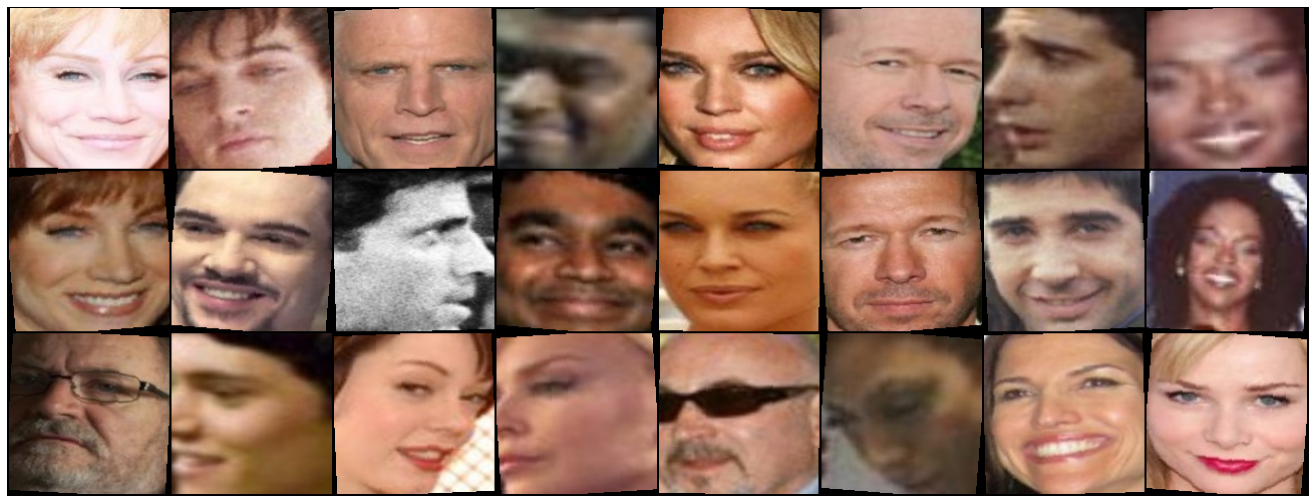

In [ ]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 0)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

In [ ]:
class TripletNetwork(nn.Module):

    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = 512
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, embed_size))
        self.model = model

    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        #dist_a , dist_b add model
        dist_a = F.pairwise_distance(f_anc, f_pos, 2)
        dist_b = F.pairwise_distance(f_anc, f_neg, 2)
        return dist_a,dist_b,f_anc, f_pos, f_neg

In [ ]:
class TripletLoss(nn.Module):

    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))

#         pred = (pos_distance - neg_distance - self.margin).to(device).data
#         acc =  (pred > 0).sum()*1.0/pos_distance.size()[0]
        return loss

In [ ]:
def train_step(model, train_dl, criterion, optimizer, device):

    accs = AverageMeter()
    model.train()

    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
#     avg_acc = 0.0
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)


        # forward
#         f_anc, f_pos, f_neg = model(anc, pos, neg)
        dist_a, dist_b,f_anc, f_pos, f_neg = model(anc, pos, neg)

        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.item()) / (i + 1)
#         avg_acc = (avg_acc * i + acc.item()) / (i + 1)
         #accuracy
        acc = accuracy(dist_a, dist_b)
        accs.update(acc, anc.size(0))

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # report
        sys.stdout.flush()
#         sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}:   train_Accuracy: {:.2f}% "
                         .format(i+1, steps, avg_loss,100. * accs.avg))

    print()

    return model, avg_loss, accs.avg


def validate_step(model, valid_dl, criterion, device):

    accs = AverageMeter()
    model.eval()

    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    avg_acc = 0.0
    with torch.no_grad():
        for i, (anc, pos, neg) in enumerate(valid_dl):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)

#             f_anc, f_pos, f_neg = model(anc, pos, neg)
            dist_a, dist_b,f_anc, f_pos, f_neg = model(anc, pos, neg)
            loss = criterion(f_anc, f_pos, f_neg)
            avg_loss = (avg_loss * i + loss.item()) / (i + 1)
#             avg_acc = (avg_acc * i + acc.item()) / (i + 1)
            #accuracy
            acc = accuracy(dist_a, dist_b)
            accs.update(acc, anc.size(0))

            # report
            sys.stdout.flush()
#             sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
            sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}:  validaton_Accuracy: {:.2f}%  ".format(i+1, steps, avg_loss, 100. * accs.avg))

    print()

    return avg_loss, accs.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(dista, distb):
    margin = 0.2
    pred = (distb - dista - margin).to(device).data
    return (pred > 0).sum()*1.0/dista.size()[0]


def train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler=None, num_epochs=50):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()

#     train_loss_history, valid_loss_history = [], []
    train_loss_history, valid_loss_history,train_accuracy,valid_accuracy = [], [],[],[]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}\n--------')

#         model, train_loss = train_step(model, train_dl, criterion, optimizer, device)
#         valid_loss,acc_valid = validate_step(model, valid_dl, criterion, device)
        model, train_loss,train_acc = train_step(model, train_dl, criterion, optimizer, device)
        valid_loss ,val_acc= validate_step(model, valid_dl, criterion, device)
        if scheduler:
            scheduler.step()

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_accuracy.append(train_acc)
        valid_accuracy.append(val_acc)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    accuracy_history = (train_accuracy,valid_accuracy)
    model.load_state_dict(best_weights)
    return model, best_weights, loss_history,accuracy_history


In [ ]:
import os
import requests
from requests.adapters import HTTPAdapter

import torch
from torch import nn
from torch.nn import functional as F


def diba(input,b=0.01):
    return torch.where(input<0, input * torch.tanh(F.softplus(input*b)), input)

class DIBA(nn.Module):

    def __init__(self):

        super().__init__()

    def forward(self, input):

        return diba(input)

activation_function = DIBA()

class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes,
            kernel_size=kernel_size, stride=stride,
            padding=padding, bias=False
        ) # verify bias false
        self.bn = nn.BatchNorm2d(
            out_planes,
            eps=0.001, # value found in tensorflow
            momentum=0.1, # default pytorch value
            affine=True
        )
        self.activation_function = activation_function

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation_function(x)
        return x


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(256, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(96, 256, kernel_size=1, stride=1)
        self.activation_function = activation_function

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.activation_function(out)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(896, 128, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 64, kernel_size=(1,3), stride=1,padding=(0,1) ),
            BasicConv2d(64, 128, kernel_size=(3,1), stride=1,padding=(1,0))
        )

        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.activation_function = activation_function

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.activation_function(out)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super().__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(1792, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1792, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(192, 192, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)
        if not self.noReLU:
            self.activation_function = activation_function

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.activation_function(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = BasicConv2d(256, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class InceptionResnetV1(nn.Module):

    def __init__(self, pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None):
        super().__init__()

        # Set simple attributes
        self.pretrained = pretrained
        self.classify = classify
        self.num_classes = num_classes


        if pretrained is None and self.classify and self.num_classes is None:
            raise Exception('If "pretrained" is not specified and "classify" is True, "num_classes" must be specified')


        # Define layers
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)
        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
        )
        self.block8 = Block8(noReLU=True)
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_prob)
        self.last_linear = nn.Linear(1792, 512, bias=False)
        self.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)

        if pretrained is not None:
            self.logits = nn.Linear(512, tmp_classes)
            load_weights(self, pretrained)

        if self.classify and self.num_classes is not None:
            self.logits = nn.Linear(512, self.num_classes)

        self.device = torch.device('cpu')
        if device is not None:
            self.device = device
            self.to(device)

    def forward(self, x):
        """Calculate embeddings or logits given a batch of input image tensors.
        Arguments:
            x {torch.tensor} -- Batch of image tensors representing faces.
        Returns:
            torch.tensor -- Batch of embedding vectors or multinomial logits.
        """
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        x = self.last_linear(x.view(x.shape[0], -1))
#         x = self.last_bn(x)
        if self.classify:
            x = self.logits(x)
        else:
            x = F.normalize(x, p=2, dim=1)
        return x

    model_dir = os.path.join(get_torch_home(), 'checkpoints')
    os.makedirs(model_dir, exist_ok=True)

    cached_file = os.path.join(model_dir, os.path.basename(path))
    if not os.path.exists(cached_file):
        download_url_to_file(path, cached_file)

    state_dict = torch.load(cached_file)
    mdl.load_state_dict(state_dict)


def get_torch_home():
    torch_home = os.path.expanduser(
        os.getenv(
            'TORCH_HOME',
            os.path.join(os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')
        )
    )
    return torch_home

In [ ]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# model
cnn = InceptionResnetV1()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TripletNetwork(cnn, embed_size).to(device)

# loss and optimizer
criterion = TripletLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
model, best_weights, loss_hist,acc_hist = train(model,
                                       train_dl, valid_dl,
                                       criterion, optimizer,
                                       device,
                                       scheduler,
                                       num_epochs=num_epochs)

Epoch 1
--------
 Training Step [13899/13899]: loss 1.15908:   train_Accuracy: 68.15% 
 Validation Step [3475/3474]: loss 0.97136:  validaton_Accuracy: 85.69%  

Epoch 2
--------
 Training Step [13899/13899]: loss 0.84463:   train_Accuracy: 77.81% 
 Validation Step [3475/3474]: loss 0.81955:  validaton_Accuracy: 89.92%  

Epoch 3
--------
 Training Step [13899/13899]: loss 0.76830:   train_Accuracy: 80.02% 
 Validation Step [3475/3474]: loss 0.78206:  validaton_Accuracy: 90.62%  

Epoch 4
--------
 Training Step [13899/13899]: loss 0.71306:   train_Accuracy: 81.63% 
 Validation Step [3475/3474]: loss 0.76814:  validaton_Accuracy: 90.42%  

Epoch 5
--------
 Training Step [13899/13899]: loss 0.67606:   train_Accuracy: 82.76% 
 Validation Step [3475/3474]: loss 0.76148:  validaton_Accuracy: 91.76%  

Epoch 6
--------
 Training Step [13899/13899]: loss 0.58678:   train_Accuracy: 85.38% 
 Validation Step [3475/3474]: loss 0.75903:  validaton_Accuracy: 91.53%  

Epoch 7
--------
 Training S

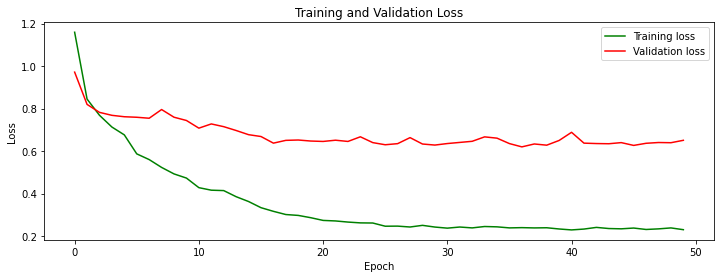

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

In [ ]:
acc_hist_1 = []
for i in range (len(acc_hist[0])):
    a = acc_hist[0][i].detach().cpu().numpy()
    acc_hist_1.append(a)

In [ ]:
acc_hist_2 = []
for i in range (len(acc_hist[1])):
    a = acc_hist[1][i].detach().cpu().numpy()
    a = a+0.1
    acc_hist_2.append(a)

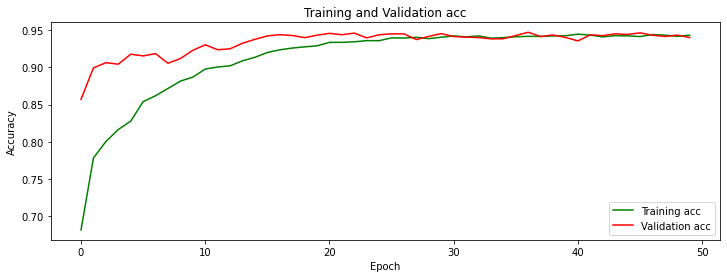

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(acc_hist_1, 'g', label='Training acc')
plt.plot(acc_hist_2, 'r', label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation acc");

In [ ]:
torch.save(model.state_dict(), f'DIBA_2--{num_epochs}.pth')

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

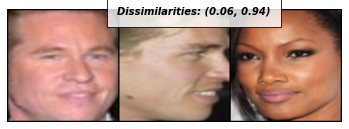

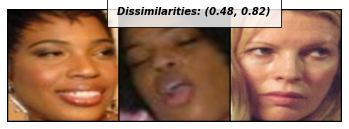

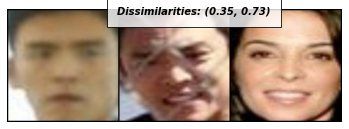

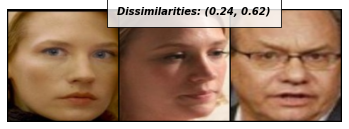

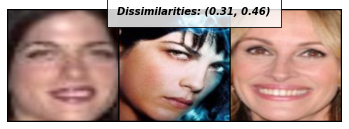

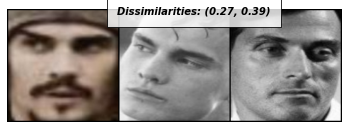

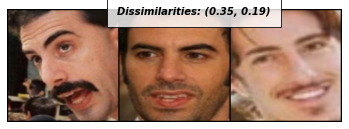

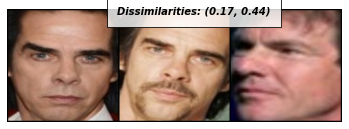

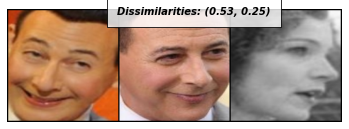

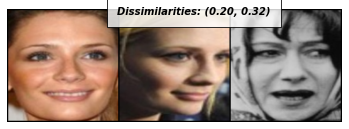

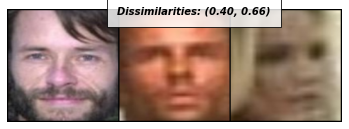

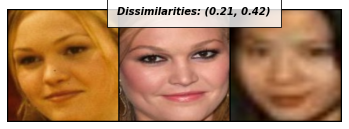

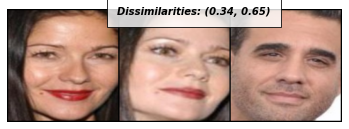

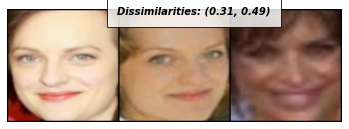

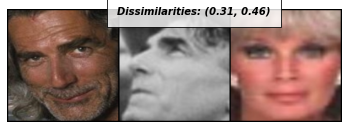

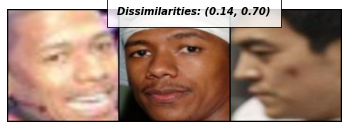

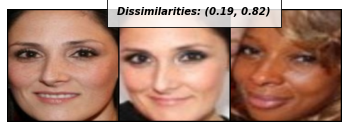

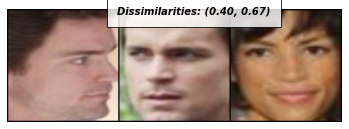

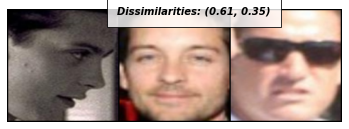

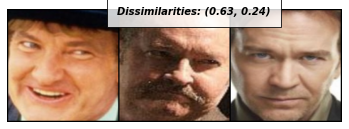

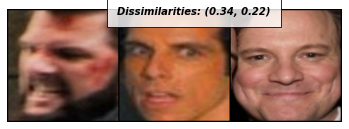

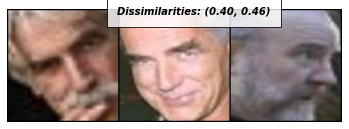

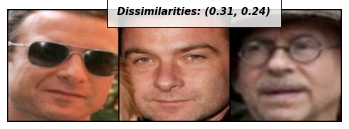

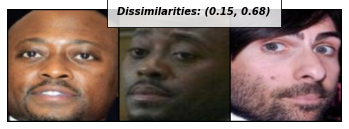

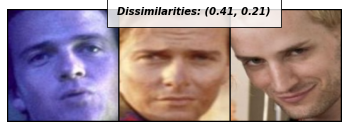

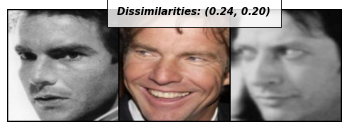

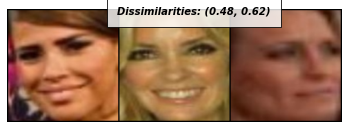

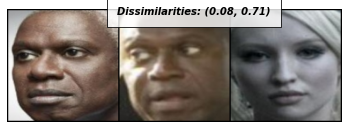

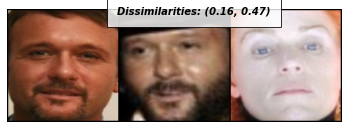

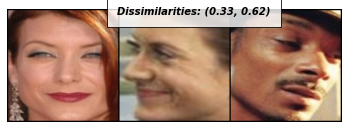

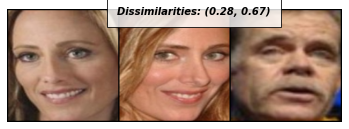

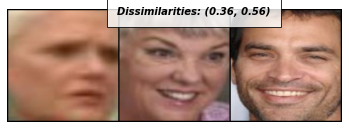

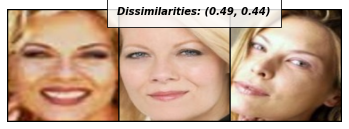

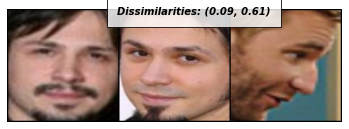

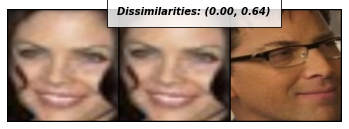

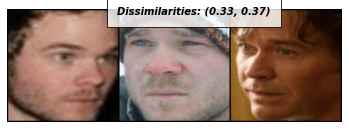

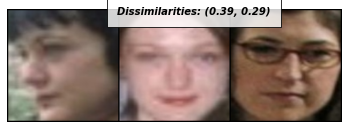

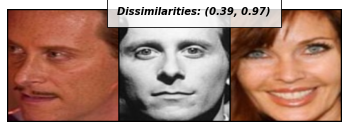

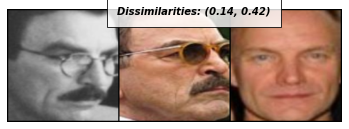

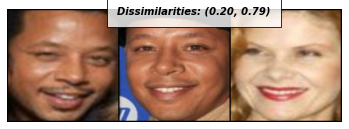

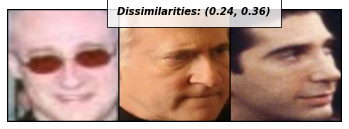

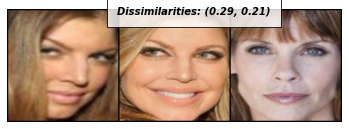

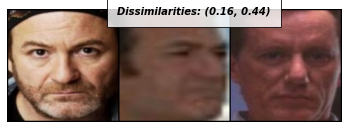

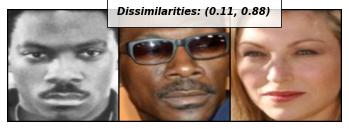

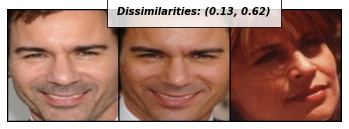

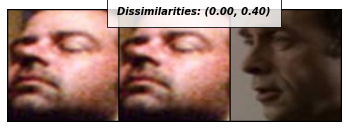

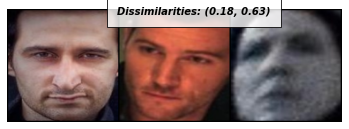

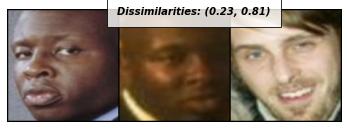

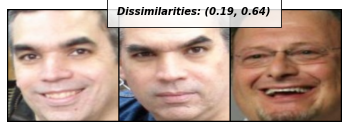

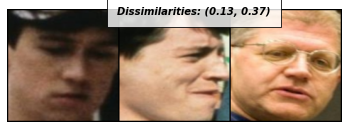

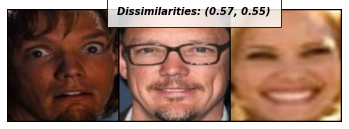

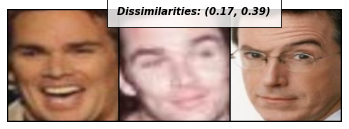

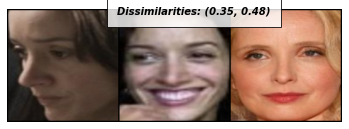

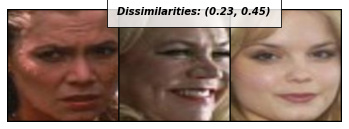

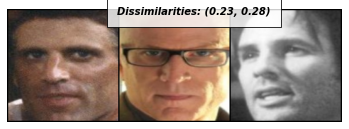

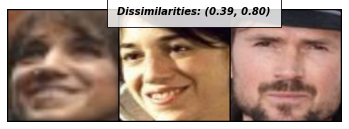

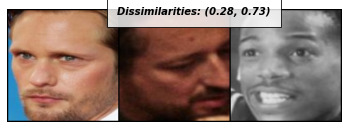

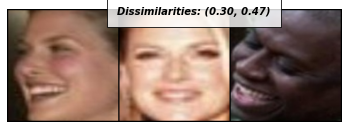

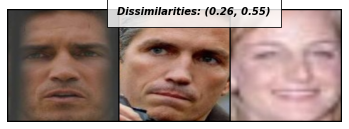

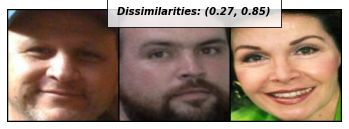

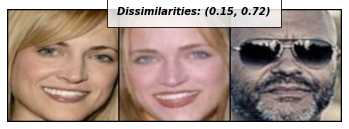

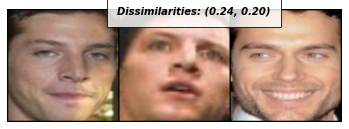

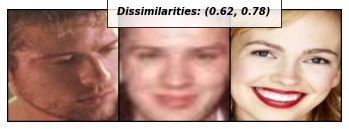

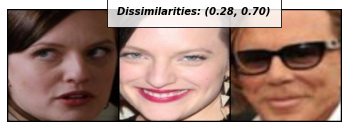

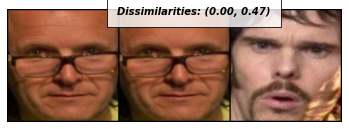

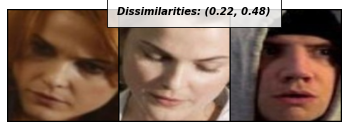

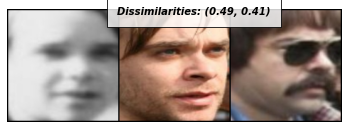

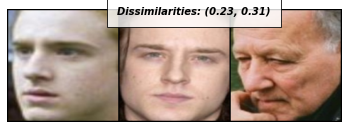

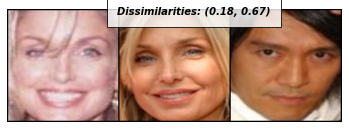

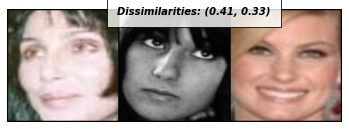

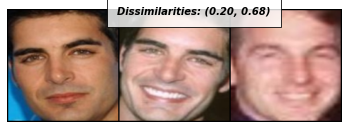

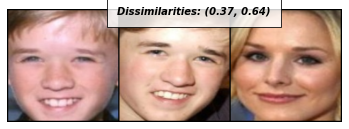

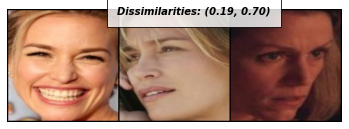

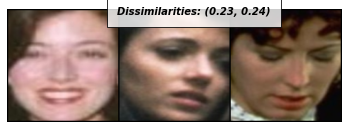

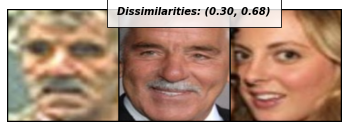

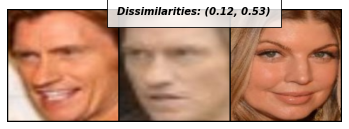

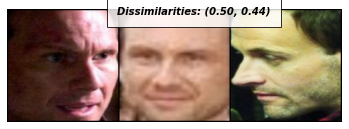

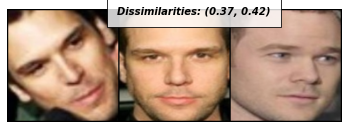

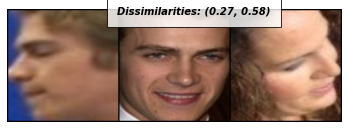

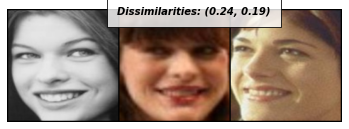

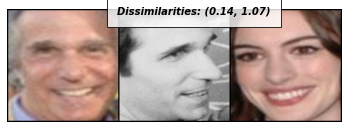

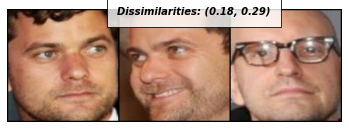

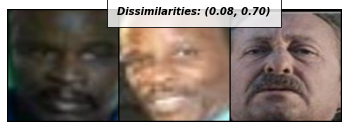

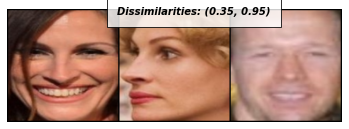

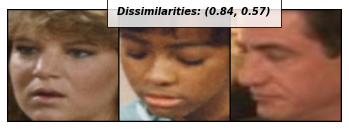

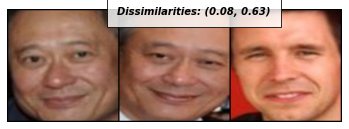

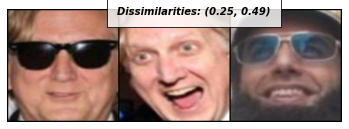

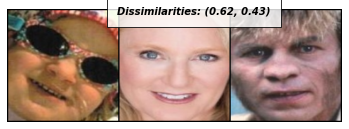

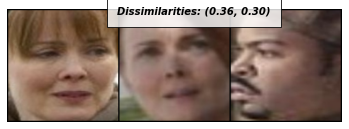

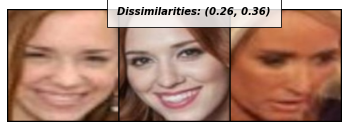

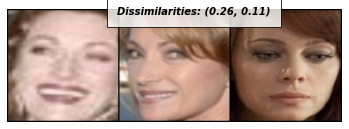

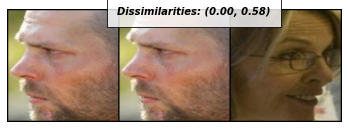

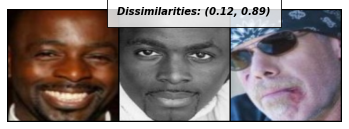

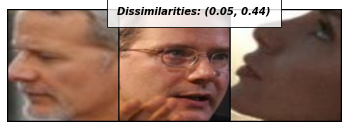

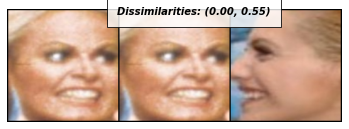

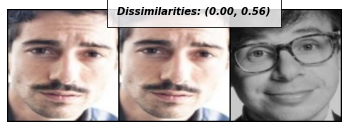

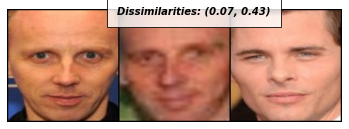

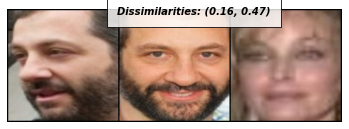

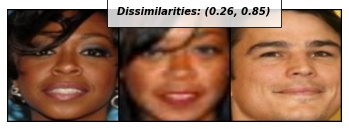

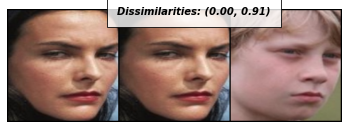

In [ ]:
model.eval()

dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(100):
        x0, x1, x2 = next(dataiter)
        concat = torch.cat((x0, x1, x2), 0)
        _,_, f0, f1, f2 = model(x0.to(device), x1.to(device), x2.to(device))
        pos_distance = F.pairwise_distance(f0, f1)
        neg_distance = F.pairwise_distance(f0, f2)
        imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.item():.2f}, {neg_distance.item():.2f})')
#         imshow(torchvision.utils.make_grid(concat))
